# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


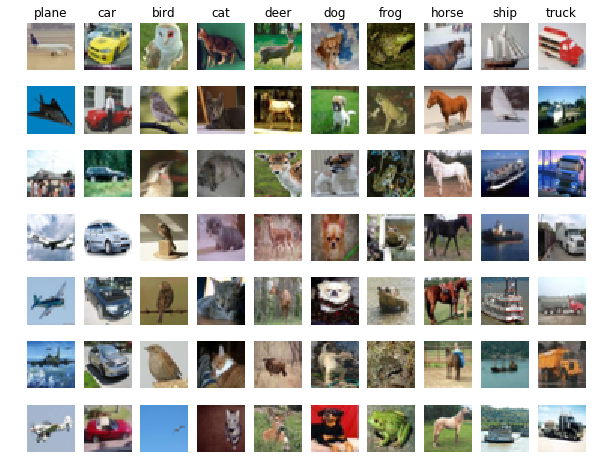

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


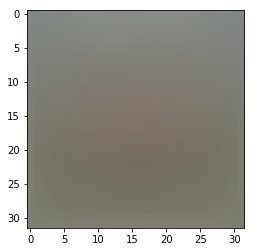

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.207654


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [37]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 8.366776 analytic: 8.366776, relative error: 1.366645e-11
numerical: 11.946428 analytic: 11.946428, relative error: 1.585847e-11
numerical: 3.235200 analytic: 3.227860, relative error: 1.135680e-03
numerical: 2.639090 analytic: 2.639090, relative error: 1.882473e-10
numerical: 1.323081 analytic: 1.323081, relative error: 3.049306e-10
numerical: 10.626698 analytic: 10.626698, relative error: 8.365931e-12
numerical: -0.363069 analytic: -0.363069, relative error: 6.007926e-11
numerical: -18.537756 analytic: -18.556403, relative error: 5.027044e-04
numerical: 19.353077 analytic: 19.353077, relative error: 2.102285e-12
numerical: 8.334431 analytic: 8.334431, relative error: 1.383671e-12
numerical: 15.112278 analytic: 15.112278, relative error: 1.950001e-11
numerical: -27.160497 analytic: -27.171647, relative error: 2.052149e-04
numerical: -44.401452 analytic: -44.401452, relative error: 8.832845e-12
numerical: 10.814442 analytic: 10.814442, relative error: 3.924391e-11
numerical:

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [28]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.207654e+00 computed in 0.100951s
Vectorized loss: 9.207654e+00 computed in 0.003075s
difference: 0.000000


In [36]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print (grad_naive)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
print (grad_vectorized)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

[[ -2.93995273e+01   8.92609490e+00   9.04588004e+00 ...,  -1.97842310e+01
   -1.81102417e+01  -2.35871227e+01]
 [ -3.40511598e+01   7.79308674e+00   1.31109953e+01 ...,  -2.22262373e+01
   -3.22526029e+01  -2.58428949e+01]
 [ -5.17258002e+01   3.64569592e+00   2.84138536e+01 ...,  -2.41396272e+01
   -5.92205726e+01  -3.55845661e+01]
 ..., 
 [ -2.78976501e+01   1.06709796e+00  -1.47398232e+01 ...,  -1.17895636e+01
    2.30052137e+01   8.15466938e-01]
 [ -3.89763803e+01  -5.44002143e+00  -5.41651743e+00 ...,   6.16882855e-02
   -2.53130800e+00  -8.29927143e-01]
 [  4.60000003e-02  -4.99999992e-02  -2.74000000e-01 ...,   2.06000001e-01
   -2.52000000e-01   1.70000000e-01]]
Naive loss and gradient: computed in 0.127516s
[[  0.39667185  16.31725129   5.22865166 ...,   1.20063783 -13.23611408
    9.57422276]
 [ -1.19595952  13.83634009   4.80376189 ...,   0.61523904 -14.98581776
   10.82881259]
 [ -2.4137212   12.49571545   8.86019867 ...,   2.35318052 -17.3505002
   12.60293841]
 ..., 
 [ 

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [32]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 401.821376
iteration 1 / 1500: loss 401.371471
iteration 2 / 1500: loss 398.993476
iteration 3 / 1500: loss 395.933378
iteration 4 / 1500: loss 391.681372
iteration 5 / 1500: loss 392.703269
iteration 6 / 1500: loss 387.300463
iteration 7 / 1500: loss 385.979753
iteration 8 / 1500: loss 382.117832
iteration 9 / 1500: loss 383.223809
iteration 10 / 1500: loss 379.383966
iteration 11 / 1500: loss 377.129242
iteration 12 / 1500: loss 376.932685
iteration 13 / 1500: loss 372.291855
iteration 14 / 1500: loss 372.726859
iteration 15 / 1500: loss 369.764735
iteration 16 / 1500: loss 368.777908
iteration 17 / 1500: loss 365.503398
iteration 18 / 1500: loss 362.559379
iteration 19 / 1500: loss 361.020275
iteration 20 / 1500: loss 360.368436
iteration 21 / 1500: loss 359.239621
iteration 22 / 1500: loss 357.087733
iteration 23 / 1500: loss 354.650002
iteration 24 / 1500: loss 352.493141
iteration 25 / 1500: loss 351.108401
iteration 26 / 1500: loss 350.383028
iteration 2

iteration 221 / 1500: loss 131.923078
iteration 222 / 1500: loss 131.679179
iteration 223 / 1500: loss 131.764816
iteration 224 / 1500: loss 131.004301
iteration 225 / 1500: loss 129.737717
iteration 226 / 1500: loss 129.003494
iteration 227 / 1500: loss 129.452341
iteration 228 / 1500: loss 128.001137
iteration 229 / 1500: loss 127.554667
iteration 230 / 1500: loss 127.118729
iteration 231 / 1500: loss 125.905397
iteration 232 / 1500: loss 124.997888
iteration 233 / 1500: loss 125.013427
iteration 234 / 1500: loss 124.163294
iteration 235 / 1500: loss 123.707781
iteration 236 / 1500: loss 123.679920
iteration 237 / 1500: loss 122.900795
iteration 238 / 1500: loss 121.759835
iteration 239 / 1500: loss 121.958782
iteration 240 / 1500: loss 121.579461
iteration 241 / 1500: loss 120.714586
iteration 242 / 1500: loss 119.710939
iteration 243 / 1500: loss 119.430198
iteration 244 / 1500: loss 118.704382
iteration 245 / 1500: loss 118.014355
iteration 246 / 1500: loss 116.813279
iteration 24

iteration 445 / 1500: loss 47.690132
iteration 446 / 1500: loss 47.858988
iteration 447 / 1500: loss 47.697049
iteration 448 / 1500: loss 47.577101
iteration 449 / 1500: loss 47.143541
iteration 450 / 1500: loss 46.638709
iteration 451 / 1500: loss 47.266885
iteration 452 / 1500: loss 46.332434
iteration 453 / 1500: loss 46.908486
iteration 454 / 1500: loss 46.089376
iteration 455 / 1500: loss 45.388682
iteration 456 / 1500: loss 45.838083
iteration 457 / 1500: loss 45.713001
iteration 458 / 1500: loss 45.070430
iteration 459 / 1500: loss 45.129369
iteration 460 / 1500: loss 45.415695
iteration 461 / 1500: loss 44.752359
iteration 462 / 1500: loss 44.649230
iteration 463 / 1500: loss 44.597139
iteration 464 / 1500: loss 44.641453
iteration 465 / 1500: loss 44.038266
iteration 466 / 1500: loss 43.347297
iteration 467 / 1500: loss 44.105549
iteration 468 / 1500: loss 43.416656
iteration 469 / 1500: loss 43.545021
iteration 470 / 1500: loss 43.673958
iteration 471 / 1500: loss 42.891720
i

iteration 669 / 1500: loss 20.904984
iteration 670 / 1500: loss 21.006488
iteration 671 / 1500: loss 20.828437
iteration 672 / 1500: loss 20.780198
iteration 673 / 1500: loss 20.742931
iteration 674 / 1500: loss 20.751342
iteration 675 / 1500: loss 20.684220
iteration 676 / 1500: loss 20.506141
iteration 677 / 1500: loss 20.859119
iteration 678 / 1500: loss 20.588127
iteration 679 / 1500: loss 20.222060
iteration 680 / 1500: loss 20.569675
iteration 681 / 1500: loss 20.166673
iteration 682 / 1500: loss 20.069440
iteration 683 / 1500: loss 20.396768
iteration 684 / 1500: loss 19.977863
iteration 685 / 1500: loss 19.876538
iteration 686 / 1500: loss 20.080213
iteration 687 / 1500: loss 19.689334
iteration 688 / 1500: loss 19.999395
iteration 689 / 1500: loss 19.895791
iteration 690 / 1500: loss 19.911175
iteration 691 / 1500: loss 19.544197
iteration 692 / 1500: loss 19.604900
iteration 693 / 1500: loss 19.599288
iteration 694 / 1500: loss 19.573292
iteration 695 / 1500: loss 19.492104
i

iteration 895 / 1500: loss 12.296509
iteration 896 / 1500: loss 12.221264
iteration 897 / 1500: loss 12.288678
iteration 898 / 1500: loss 12.265634
iteration 899 / 1500: loss 12.141894
iteration 900 / 1500: loss 12.335251
iteration 901 / 1500: loss 12.353370
iteration 902 / 1500: loss 12.123630
iteration 903 / 1500: loss 12.177538
iteration 904 / 1500: loss 11.997693
iteration 905 / 1500: loss 11.985482
iteration 906 / 1500: loss 12.161045
iteration 907 / 1500: loss 12.023355
iteration 908 / 1500: loss 11.960035
iteration 909 / 1500: loss 12.030052
iteration 910 / 1500: loss 12.065833
iteration 911 / 1500: loss 12.116705
iteration 912 / 1500: loss 11.853894
iteration 913 / 1500: loss 12.053452
iteration 914 / 1500: loss 11.856836
iteration 915 / 1500: loss 11.980137
iteration 916 / 1500: loss 11.906441
iteration 917 / 1500: loss 11.980428
iteration 918 / 1500: loss 11.802433
iteration 919 / 1500: loss 11.826754
iteration 920 / 1500: loss 11.875278
iteration 921 / 1500: loss 11.806058
i

iteration 1121 / 1500: loss 9.712555
iteration 1122 / 1500: loss 9.636914
iteration 1123 / 1500: loss 9.428633
iteration 1124 / 1500: loss 9.501947
iteration 1125 / 1500: loss 9.729554
iteration 1126 / 1500: loss 9.561847
iteration 1127 / 1500: loss 9.536778
iteration 1128 / 1500: loss 9.528503
iteration 1129 / 1500: loss 9.466263
iteration 1130 / 1500: loss 9.370833
iteration 1131 / 1500: loss 9.436468
iteration 1132 / 1500: loss 9.500051
iteration 1133 / 1500: loss 9.479728
iteration 1134 / 1500: loss 9.400897
iteration 1135 / 1500: loss 9.430995
iteration 1136 / 1500: loss 9.584852
iteration 1137 / 1500: loss 9.582452
iteration 1138 / 1500: loss 9.461642
iteration 1139 / 1500: loss 9.579417
iteration 1140 / 1500: loss 9.395263
iteration 1141 / 1500: loss 9.508173
iteration 1142 / 1500: loss 9.498605
iteration 1143 / 1500: loss 9.395093
iteration 1144 / 1500: loss 9.491478
iteration 1145 / 1500: loss 9.512235
iteration 1146 / 1500: loss 9.377799
iteration 1147 / 1500: loss 9.446694
i

iteration 1346 / 1500: loss 8.700642
iteration 1347 / 1500: loss 8.722562
iteration 1348 / 1500: loss 8.752226
iteration 1349 / 1500: loss 8.680696
iteration 1350 / 1500: loss 8.579210
iteration 1351 / 1500: loss 8.664604
iteration 1352 / 1500: loss 8.505730
iteration 1353 / 1500: loss 8.661578
iteration 1354 / 1500: loss 8.601066
iteration 1355 / 1500: loss 8.665442
iteration 1356 / 1500: loss 8.604303
iteration 1357 / 1500: loss 8.669327
iteration 1358 / 1500: loss 8.645599
iteration 1359 / 1500: loss 8.670830
iteration 1360 / 1500: loss 8.668073
iteration 1361 / 1500: loss 8.691305
iteration 1362 / 1500: loss 8.697432
iteration 1363 / 1500: loss 8.731788
iteration 1364 / 1500: loss 8.662138
iteration 1365 / 1500: loss 8.729849
iteration 1366 / 1500: loss 8.677148
iteration 1367 / 1500: loss 8.762012
iteration 1368 / 1500: loss 8.609875
iteration 1369 / 1500: loss 8.723681
iteration 1370 / 1500: loss 8.617679
iteration 1371 / 1500: loss 8.803843
iteration 1372 / 1500: loss 8.684075
i

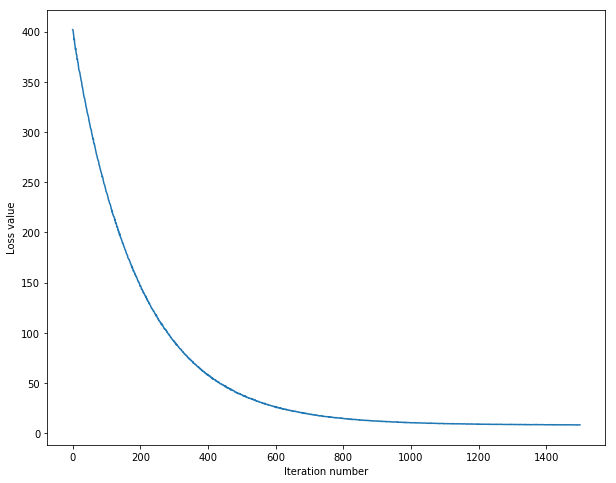

In [33]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [34]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.380735
validation accuracy: 0.402000


In [45]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, lr, reg, num_iters=2000, verbose=False)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(lr,reg)] = (training_accuracy,validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

cs231n/classifiers/linear_svm.py:112: RuntimeWarning: overflow encountered in double_scalars
  #############################################################################
cs231n/classifiers/linear_svm.py:112: RuntimeWarning: overflow encountered in multiply
  #############################################################################
cs231n/classifiers/linear_svm.py:106: RuntimeWarning: invalid value encountered in subtract
  lossmatrix[:lossmatrix.shape[0],y] = 0
cs231n/classifiers/linear_svm.py:107: RuntimeWarning: invalid value encountered in less
  


lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.389163 val accuracy: 0.402000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.357857 val accuracy: 0.360000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.402000


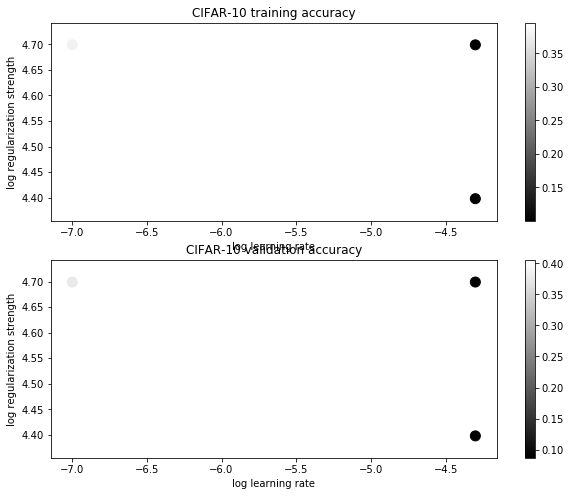

In [39]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [40]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.377000


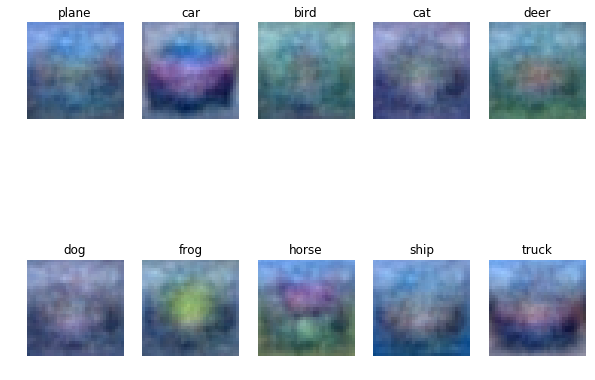

In [46]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*